# WhatToLabel - The Samples you don't need: Fashion-MNIST

In this notebook we will explore various subsampling techniques on the Fashion-MNIST dataset.



### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
import argparse
from datetime import datetime
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
from torchvision import datasets, transforms, models
import numpy as np
from prefetch_generator import BackgroundGenerator

## Data Preparation

### Parameters

In [3]:
seed=42
n_samples_keep=45_000
batch_size=128
epochs=100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Ensure reproducibility by setting seed

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [6]:
transform_test = transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [7]:
dataset_train = datasets.FashionMNIST(root='fashion-mnist',
                                     train=True,
                                      download=True,
                                     transform=transform_train)

In [8]:
dataset_test = datasets.FashionMNIST(root='fashion-mnist',
                                     train=False,
                                      download=True,
                                     transform=transform_train)

In [9]:
permutation = np.random.permutation(np.arange(len(dataset_train)))
indices_rnd = permutation[:n_samples_keep]

In [10]:
indices_wtl = np.load('fmnist_indices_top_45k.npy')

In [11]:
dataloader_train_full = data.DataLoader(dataset_train,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=8)

In [12]:
dataloader_train_rnd = data.DataLoader(dataset_train,
                                   batch_size=batch_size,
                                   sampler=data.SubsetRandomSampler(indices_rnd),
                                   num_workers=8)

In [13]:
dataloader_train_wtl = data.DataLoader(dataset_train,
                                   batch_size=batch_size,
                                   sampler=data.SubsetRandomSampler(indices_wtl),
                                   num_workers=8)

In [14]:
dataloader_test = data.DataLoader(dataset_test, 
                                  batch_size=batch_size, 
                                  shuffle=True,
                                  num_workers=8)

## Helper functions for weight balancing and evaluation

In [15]:
def get_samples_per_class(dataloader, n_classes):
    labels = []
    for data in dataloader:
        images, label = data
        labels.extend(label.cpu().numpy())
    n_samples_per_label = [labels.count(i) for i in range(n_classes)]
    return n_samples_per_label

In [16]:
def eval_model(net):
    net.eval()
    correct = 0
    total = 0
    accuracy = 0.0
    with torch.no_grad():
        for data in BackgroundGenerator(dataloader_test, 3):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

## Train routine

In [17]:
def train(dataloader_train, dataloader_test):
    n_samples_per_class = get_samples_per_class(dataloader_train, 10)
    max_samples_per_class = max(n_samples_per_class)
    weight = [max_samples_per_class / x for x in n_samples_per_class]
    class_weight = torch.FloatTensor(weight).to(device)
    
    net = models.resnet34(num_classes=10).to(device)
    
    net.train()
    
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    criterion = nn.CrossEntropyLoss(weight=class_weight)
    
    loss_lst = []
    acc_lst = []
    
    print(f'Start training on dataset of size {len(dataloader_train)}...', flush=True)
    best_accuracy = 0.0

    n_iter = 0
    loss = 0.0
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_loss = []
        if epoch in [60, 80]:
            scheduler.step()
            print(f'Updated lr')
        for i, data in enumerate(BackgroundGenerator(dataloader_train, 3), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

            n_iter += 1

        print('[%s] [%6d][%d, %5d] loss: %.4f' % (
        datetime.now().strftime("%H:%M:%S.%f"), n_iter, epoch + 1, i + 1, np.mean(epoch_loss)))

        accuracy = eval_model(net)
        loss_lst.append(np.mean(epoch_loss))
        acc_lst.append(accuracy)
        net.train()
        if accuracy > best_accuracy:
            best_accuracy = accuracy

        print(f'Accuracy of the network on the test images: {accuracy:.2f}, best accuracy: {best_accuracy:.2f}')
    return loss_lst, acc_lst

## Experiments

In [18]:
loss_rnd, acc_rnd = train(dataloader_train_rnd, dataloader_test)

Start training on dataset of size 352...
[14:59:05.414196] [   352][1,   352] loss: 0.7939
Accuracy of the network on the test images: 82.02, best accuracy: 82.02
[14:59:18.296914] [   704][2,   352] loss: 0.4386
Accuracy of the network on the test images: 82.83, best accuracy: 82.83
[14:59:31.129977] [  1056][3,   352] loss: 0.3686
Accuracy of the network on the test images: 84.58, best accuracy: 84.58
[14:59:44.132371] [  1408][4,   352] loss: 0.5449
Accuracy of the network on the test images: 75.24, best accuracy: 84.58
[14:59:57.078492] [  1760][5,   352] loss: 0.4917
Accuracy of the network on the test images: 83.32, best accuracy: 84.58
[15:00:09.834929] [  2112][6,   352] loss: 0.4008
Accuracy of the network on the test images: 84.15, best accuracy: 84.58
[15:00:22.710296] [  2464][7,   352] loss: 0.3597
Accuracy of the network on the test images: 85.47, best accuracy: 85.47
[15:00:35.511576] [  2816][8,   352] loss: 0.3343
Accuracy of the network on the test images: 86.63, best

In [19]:
loss_wtl, acc_wtl = train(dataloader_train_wtl, dataloader_test)

Start training on dataset of size 352...
[15:20:32.066264] [   352][1,   352] loss: 2.1019
Accuracy of the network on the test images: 65.70, best accuracy: 65.70
[15:20:44.763700] [   704][2,   352] loss: 0.7174
Accuracy of the network on the test images: 76.59, best accuracy: 76.59
[15:20:57.560715] [  1056][3,   352] loss: 0.5742
Accuracy of the network on the test images: 80.63, best accuracy: 80.63
[15:21:10.409393] [  1408][4,   352] loss: 0.5055
Accuracy of the network on the test images: 83.11, best accuracy: 83.11
[15:21:23.172865] [  1760][5,   352] loss: 0.4424
Accuracy of the network on the test images: 84.97, best accuracy: 84.97
[15:21:35.990629] [  2112][6,   352] loss: 0.4043
Accuracy of the network on the test images: 81.89, best accuracy: 84.97
[15:21:48.700745] [  2464][7,   352] loss: 0.3805
Accuracy of the network on the test images: 86.66, best accuracy: 86.66
[15:22:01.373314] [  2816][8,   352] loss: 0.3597
Accuracy of the network on the test images: 87.11, best

In [20]:
loss_full, acc_full = train(dataloader_train_full, dataloader_test)

Start training on dataset of size 469...
[15:41:57.203857] [   469][1,   469] loss: 1.5042
Accuracy of the network on the test images: 68.19, best accuracy: 68.19
[15:42:13.053923] [   938][2,   469] loss: 0.5628
Accuracy of the network on the test images: 79.45, best accuracy: 79.45
[15:42:28.767362] [  1407][3,   469] loss: 0.4181
Accuracy of the network on the test images: 83.92, best accuracy: 83.92
[15:42:44.573016] [  1876][4,   469] loss: 0.3549
Accuracy of the network on the test images: 84.52, best accuracy: 84.52
[15:43:00.508917] [  2345][5,   469] loss: 0.3327
Accuracy of the network on the test images: 87.82, best accuracy: 87.82
[15:43:16.339836] [  2814][6,   469] loss: 0.3156
Accuracy of the network on the test images: 88.10, best accuracy: 88.10
[15:43:32.103643] [  3283][7,   469] loss: 0.3031
Accuracy of the network on the test images: 86.15, best accuracy: 88.10
[15:43:47.794100] [  3752][8,   469] loss: 0.2973
Accuracy of the network on the test images: 86.50, best

## Analysis of the Results

In [21]:
x = np.arange(len(loss_wtl))

In [40]:
sns.set(style='whitegrid', context='talk', rc={'figure.figsize': (12,8)})

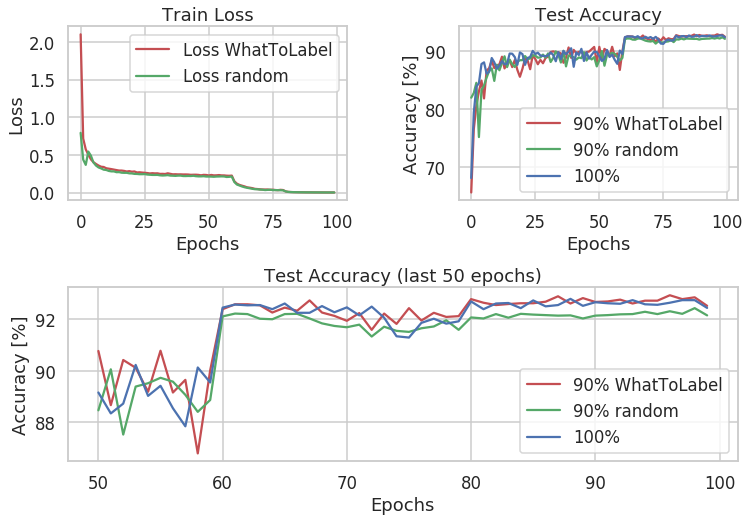

In [41]:
plt.subplots_adjust(wspace=0.4, hspace=0.5)

ax1 = plt.subplot(221)
ax1.plot(x, loss_wtl, 'r-', label='Loss WhatToLabel')
ax1.plot(x, loss_rnd, 'g-', label='Loss random')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')

ax2 = plt.subplot(222)
ax2.plot(x, acc_wtl, 'r-', label='90% WhatToLabel')
ax2.plot(x, acc_rnd, 'g-', label='90% random')
ax2.plot(x, acc_full, 'b-', label='100%')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy [%]')
ax2.set_title('Test Accuracy')


ax3 = plt.subplot(212)
ax3.plot(x[50:], acc_wtl[50:], 'r-', label='90% WhatToLabel')
ax3.plot(x[50:], acc_rnd[50:], 'g-', label='90% random')
ax3.plot(x[50:], acc_full[50:], 'b-', label='100%')
ax3.legend()
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy [%]')
ax3.set_title('Test Accuracy (last 50 epochs)')

plt.show()